In [19]:
import pandas as pd
import pickle
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
import seaborn as sns

In [20]:
df = pd.read_csv("./clean_train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77592 entries, 0 to 77591
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     77592 non-null  int64  
 1   Age                       77592 non-null  float64
 2   Occupation                77592 non-null  int64  
 3   Annual_Income             77592 non-null  float64
 4   Monthly_Inhand_Salary     77592 non-null  float64
 5   Num_Bank_Accounts         77592 non-null  float64
 6   Num_Credit_Card           77592 non-null  float64
 7   Interest_Rate             77592 non-null  float64
 8   Num_of_Loan               77592 non-null  int64  
 9   Delay_from_due_date       77592 non-null  float64
 10  Num_of_Delayed_Payment    77592 non-null  float64
 11  Changed_Credit_Limit      77592 non-null  float64
 12  Num_Credit_Inquiries      77592 non-null  float64
 13  Credit_Mix                77592 non-null  int64  
 14  Outsta

In [21]:
def kfold_metrics(clf, X, y):
    accuracy = []
    f1 = []
    precision = []
    recall = []
    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=36)
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy.append(metrics.accuracy_score(y_test, y_pred))
        precision.append(metrics.precision_score(y_test, y_pred, average=None))
        recall.append(metrics.recall_score(y_test, y_pred, average=None))
        f1.append(metrics.f1_score(y_test, y_pred, average=None))
    print("accuracy", np.mean(accuracy))
    print("precision", np.mean(precision, axis=0))
    print("recall",np.mean(recall, axis=0))
    print("f1",np.mean(f1, axis=0))

In [22]:
labels = ['Poor', 'Standard', 'Good']

In [23]:
X = df.drop(['Credit_Score'], axis=1)
y = df['Credit_Score']
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=36)

print(X_train.shape, y_train.shape)

(62073, 31) (62073,)


In [24]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), 
             index=['True ' + x for x in labels], 
             columns=['Predict ' + x for x in labels]))
print(metrics.classification_report(y_test, y_pred, target_names=labels))

               Predict Poor  Predict Standard  Predict Good
True Poor              3236              1207           123
True Standard          1169              6317           824
True Good               137               858          1648
              precision    recall  f1-score   support

        Poor       0.71      0.71      0.71      4566
    Standard       0.75      0.76      0.76      8310
        Good       0.64      0.62      0.63      2643

    accuracy                           0.72     15519
   macro avg       0.70      0.70      0.70     15519
weighted avg       0.72      0.72      0.72     15519



In [25]:
kfold_metrics(clf, X, y)

accuracy 0.7156278997834828
precision [0.70469903 0.75081125 0.62295029]
recall [0.70543628 0.75262958 0.61690375]
f1 [0.70504784 0.75171379 0.61989388]


Độ chính xác khi sử dụng DecisionTree là khoảng 71.5%

In [26]:
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), 
             index=['True ' + x for x in labels], 
             columns=['Predict ' + x for x in labels]))
print(metrics.classification_report(y_test, y_pred, target_names=labels))

               Predict Poor  Predict Standard  Predict Good
True Poor              3868               677            21
True Standard           941              6891           478
True Good                11               638          1994
              precision    recall  f1-score   support

        Poor       0.80      0.85      0.82      4566
    Standard       0.84      0.83      0.83      8310
        Good       0.80      0.75      0.78      2643

    accuracy                           0.82     15519
   macro avg       0.81      0.81      0.81     15519
weighted avg       0.82      0.82      0.82     15519



In [27]:
kfold_metrics(clf, X, y)

accuracy 0.821656871842458
precision [0.80426539 0.84100381 0.7919523 ]
recall [0.84732984 0.82914162 0.75378329]
f1 [0.82522282 0.8350279  0.77238958]


Độ chính xác khi sử dụng RandomForest là khoảng 82%, các chỉ số kết quả đều tốt hơn so với DecisionTree

In [28]:
important_features = {}
for name, value in zip(df.drop('Credit_Score', axis=1).columns, clf.feature_importances_):
  important_features[name] = value
important_features = dict(sorted(important_features.items(), key=lambda x: x[1]))
important_features

{'Mortgage Loan': 0.007501068113319134,
 'Not Specified': 0.007578912174131513,
 'Home Equity Loan': 0.007709347422329376,
 'Auto Loan': 0.007750539371070831,
 'Student Loan': 0.00787008503767914,
 'Credit-Builder Loan': 0.007901938580764177,
 'Payday Loan': 0.007914961950681774,
 'Personal Loan': 0.00805559729547927,
 'Debt Consolidation Loan': 0.008147250038016376,
 'Payment_Behaviour': 0.020141861337683194,
 'Num_of_Loan': 0.022599396433520366,
 'Occupation': 0.024343278300719234,
 'Payment_of_Min_Amount': 0.026981256451856287,
 'Num_Bank_Accounts': 0.03026191018888589,
 'Age': 0.03200814065929031,
 'Month': 0.03227903461745877,
 'Annual_Income': 0.03496865207625722,
 'Total_EMI_per_month': 0.035573625407421566,
 'Monthly_Inhand_Salary': 0.035647043164679426,
 'Num_of_Delayed_Payment': 0.036596470895647076,
 'Credit_Utilization_Ratio': 0.037780946778958865,
 'Amount_invested_monthly': 0.037790046245103584,
 'Monthly_Balance': 0.03780321666339936,
 'Num_Credit_Inquiries': 0.040581992

In [29]:
np.mean([tree.get_depth() for tree in clf.estimators_])

40.6

Tuy nhiên, số lượng feature hiện tại còn rất nhiều với depth trung bình hiện tại là 40.24

In [30]:
loans_set = ["Not Specified", "Personal Loan", "Home Equity Loan", "Credit-Builder Loan", "Auto Loan", "Mortgage Loan", "Debt Consolidation Loan", "Student Loan", "Payday Loan"]

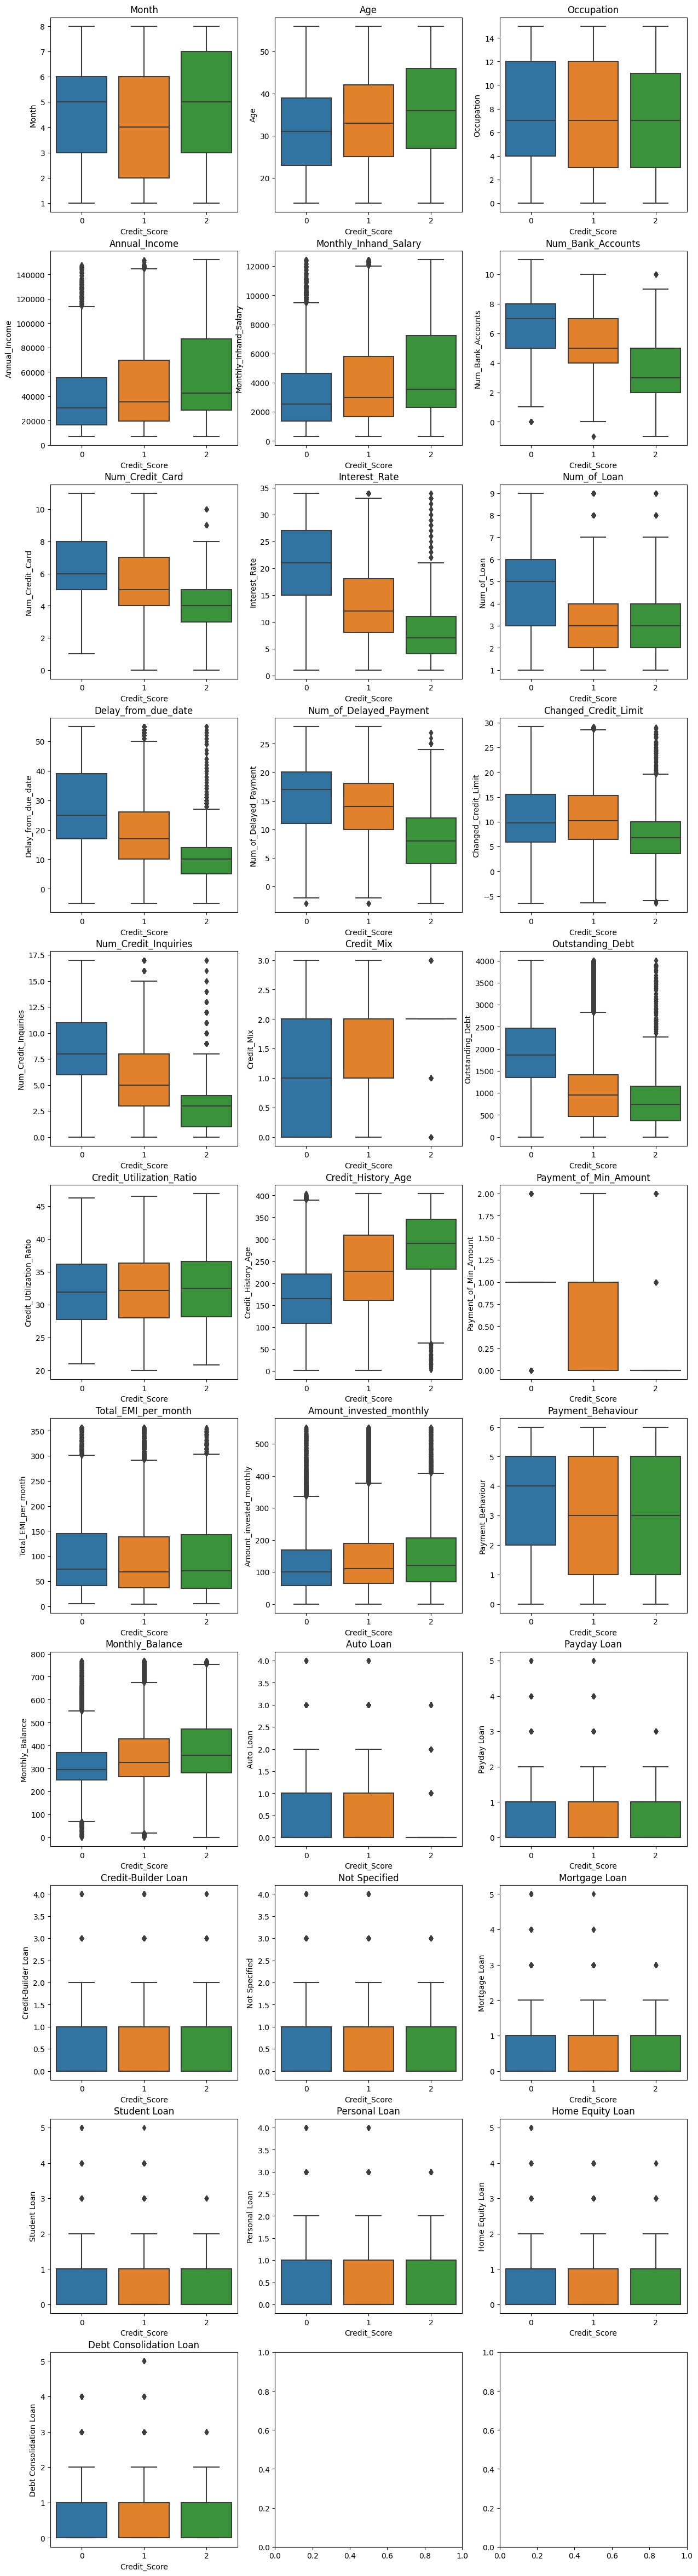

In [31]:
fig, ax = plt.subplots(11, 3, figsize=(15, 60))
for i, col in enumerate(df.drop("Credit_Score", axis=1).columns):
    ax[i//3][i%3].set_title(col)
    sns.boxplot(data=df, x=df['Credit_Score'], y=df[col], ax=ax[i//3][i%3])

In [32]:
selector = RFE(clf)
selector.fit(X_train, y_train)
print(selector.support_)
print(selector.ranking_)

[False False False  True  True False  True  True False  True  True  True
  True  True  True  True  True False  True  True False  True False False
 False False False False False False False]
[ 3  2  5  1  1  4  1  1  7  1  1  1  1  1  1  1  1  6  1  1  8  1 15  9
 10 17 16 14 11 13 12]


In [18]:
selector = SequentialFeatureSelector(clf, direction="forward", n_jobs=-1)
selector.fit(X_train, y_train)
selector.support_

c:\Python310\lib\site-packages\sklearn\feature_selection\_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


KeyboardInterrupt: 

In [44]:
print(df.drop('Credit_Score', axis=1).iloc[:, dfeatures].columns)
remain_columns = df.drop('Credit_Score', axis=1).iloc[:, [x for x in range(0, X.shape[1]) if x not in dfeatures]].columns
print(remain_columns)

Index(['Month', 'Age', 'Occupation', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Payment_of_Min_Amount',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Auto Loan', 'Credit-Builder Loan'],
      dtype='object')
Index(['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Outstanding_Debt',
       'Total_EMI_per_month', 'Payday Loan', 'Mortgage Loan',
       'Home Equity Loan', 'Debt Consolidation Loan', 'Personal Loan',
       'Student Loan', 'Not Specified'],
      dtype='object')


In [49]:
labels = ['Poor', 'Standard', 'Good']
X = np.delete(X, dfeatures, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=36)

clf = DecisionTreeClassifier(criterion='gini', class_weight=None)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(pd.DataFrame(metrics.confusion_matrix(y_val, y_pred, labels=np.unique(y_val)), 
             index=['True ' + x for x in labels], 
             columns=['Predict ' + x for x in labels]))
print(metrics.classification_report(y_val, y_pred, target_names=labels))

               Predict Poor  Predict Standard  Predict Good
True Poor              3116               107           154
True Standard           101              1842           124
True Good               144               154          3527
              precision    recall  f1-score   support

        Poor       0.93      0.92      0.92      3377
    Standard       0.88      0.89      0.88      2067
        Good       0.93      0.92      0.92      3825

    accuracy                           0.92      9269
   macro avg       0.91      0.91      0.91      9269
weighted avg       0.92      0.92      0.92      9269



In [51]:
y_pred = clf.predict(np.delete(X_test, dfeatures, 1))
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), 
             index=['True ' + x for x in labels], 
             columns=['Predict ' + x for x in labels]))
print(metrics.classification_report(y_test, y_pred, target_names=labels))

               Predict Poor  Predict Standard  Predict Good
True Poor              3006               488           278
True Standard          1449              4094          1411
True Good               158               414          1731
              precision    recall  f1-score   support

        Poor       0.65      0.80      0.72      3772
    Standard       0.82      0.59      0.69      6954
        Good       0.51      0.75      0.60      2303

    accuracy                           0.68     13029
   macro avg       0.66      0.71      0.67     13029
weighted avg       0.72      0.68      0.68     13029



In [52]:
important_features = {}
for name, value in zip(remain_columns, clf.feature_importances_):
  important_features[name] = value
important_features = dict(sorted(important_features.items(), key=lambda x: x[1]))
important_features

{'Student Loan': 0.010194152253693165,
 'Debt Consolidation Loan': 0.012203893812636474,
 'Mortgage Loan': 0.013015707215976275,
 'Home Equity Loan': 0.01319268218979961,
 'Personal Loan': 0.013209182919466435,
 'Payday Loan': 0.013468507390275075,
 'Not Specified': 0.014171515407143924,
 'Num_Credit_Card': 0.05800357376868522,
 'Total_EMI_per_month': 0.05897869977048596,
 'Annual_Income': 0.06436723631027254,
 'Monthly_Inhand_Salary': 0.0677367015870845,
 'Num_Bank_Accounts': 0.07887198832596407,
 'Interest_Rate': 0.16030581959145168,
 'Outstanding_Debt': 0.42228033945706483}

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=36)
params = {
    'max_depth': [None] + list(range(10, 60, 2)),
    'min_samples_leaf': list(range(1, 30, 2))
}
grid = GridSearchCV(decision_tree, params, cv=4, verbose=100)
grid.fit(X, y)
print(grid.best_params_)

Fitting 4 folds for each of 390 candidates, totalling 1560 fits
[CV 1/4; 1/390] START max_depth=None, min_samples_leaf=1........................
[CV 1/4; 1/390] END max_depth=None, min_samples_leaf=1;, score=0.538 total time=   0.5s
[CV 2/4; 1/390] START max_depth=None, min_samples_leaf=1........................
[CV 2/4; 1/390] END max_depth=None, min_samples_leaf=1;, score=0.527 total time=   0.4s
[CV 3/4; 1/390] START max_depth=None, min_samples_leaf=1........................
[CV 3/4; 1/390] END max_depth=None, min_samples_leaf=1;, score=0.533 total time=   0.3s
[CV 4/4; 1/390] START max_depth=None, min_samples_leaf=1........................
[CV 4/4; 1/390] END max_depth=None, min_samples_leaf=1;, score=0.521 total time=   0.4s
[CV 1/4; 2/390] START max_depth=None, min_samples_leaf=3........................
[CV 1/4; 2/390] END max_depth=None, min_samples_leaf=3;, score=0.547 total time=   0.3s
[CV 2/4; 2/390] START max_depth=None, min_samples_leaf=3........................
[CV 2/4; 2

KeyboardInterrupt: 

In [ ]:
kfold_accurate(X, y, params=grid.best_params_)

0.7049648516746275

In [ ]:
clf = DecisionTreeClassifier(**grid.best_params_, random_state=36)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), 
             index=['True ' + x for x in labels], 
             columns=['Predict ' + x for x in labels]))
print(metrics.classification_report(y_test, y_pred, target_names=labels))
print(metrics.accuracy_score(y_test, y_pred))

               Predict Poor  Predict Standard  Predict Good
True Poor              6359               761          1573
True Standard          1555              4665          2473
True Good               209              1066          7418
              precision    recall  f1-score   support

        Poor       0.78      0.73      0.76      8693
    Standard       0.72      0.54      0.61      8693
        Good       0.65      0.85      0.74      8693

    accuracy                           0.71     26079
   macro avg       0.72      0.71      0.70     26079
weighted avg       0.72      0.71      0.70     26079

0.7071590168334675


In [ ]:
clf = DecisionTreeClassifier(**grid.best_params_)
clf = clf.fit(X, y)

clf.features = remain_columns
clf.labels = labels
with open('model_l.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [ ]:
X = df.drop(['Credit_Score'], axis=1)
y = df['Credit_Score']
X = np.array(X)
y = np.array(y)
X = np.delete(X, dfeatures, 1)
y_pred = clf.predict(X)
print(pd.DataFrame(metrics.confusion_matrix(y, y_pred, labels=np.unique(y)), 
             index=['True ' + x for x in labels], 
             columns=['Predict ' + x for x in labels]))
print(metrics.classification_report(y, y_pred, target_names=labels))
print(metrics.accuracy_score(y, y_pred))

               Predict Poor  Predict Standard  Predict Good
True Poor             16271              1744           844
True Standard          5442             24501          4828
True Good               354              1141         10018
              precision    recall  f1-score   support

        Poor       0.74      0.86      0.80     18859
    Standard       0.89      0.70      0.79     34771
        Good       0.64      0.87      0.74     11513

    accuracy                           0.78     65143
   macro avg       0.76      0.81      0.77     65143
weighted avg       0.80      0.78      0.78     65143

0.7796693428303886
